In [12]:
from pandas import read_csv
from matplotlib import pyplot
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from keras.utils import to_categorical


In [13]:
colors = ['#BB0000', '#0000BB', 'green','red', 'yellow', 'pink']

def prinUserSensorData(dataS, label,s):
    df = pd.DataFrame()
    ts=[]
    ls=[]
    #print(dataS.shape)
    for t in range(0,dataS.shape[0]):
        ts.append(dataS[t][0])
    df['Time']=ts
    #print(ts)
#    for s in range(1,dataS.shape[1]):
    ls.append(label+" #column-"+str(s))
    #print(dataS[:,s].shape)
    df[label+" #column-"+str(s)]=dataS[:,s]

    print(ls)
    
    df.plot(x="Time",y=ls,subplots=True, legend=True, figsize=(15,5), color=colors[s-1])    
    


In [21]:
import numpy as np

folder = "./data"

users = ["Snozone"]
#files = ["diagonal1", "diagonal2", "diagonal3", "doublepoling1", "doublepoling2", "doublepoling3", "herringbone1", "herringbone2", "kickdoublepoling1", "kickdoublepoling2", "kickdoublepoling3"]
files = ["herringbone1", "herringbone2","diagonal1", "diagonal2", "doublepoling1", "doublepoling3", "kickdoublepoling1", "kickdoublepoling2"]

cross = [0, 1, 0, 1, 0, 1, 0, 1]

sensors = ["s1", "s2"]

tW = list(range(-2500, 100, 50))

print(tW)
print(len(tW))

tStep = 150

index_t = 0

def getAVG(vs):
    if len(vs) == 0:
        return 0
    if np.isnan(np.median(vs)):
        return -1
    return np.median(vs)

def smoothData(data):
    for ix in range(1, 6):
        data[:, ix] = data[:, ix].astype(float)
        lastV = 0.0
        for jx in range(len(data[:, ix])):
            data[jx, ix] = data[jx, ix] * 0.2 + lastV * 0.8
            lastV = data[jx, ix]

def smoothDataTime(data):
    data[:, 0] = data[:, 0].astype(float)
    tA = []
    lastT = -1
    for jx in range(len(data[:, 0])):
        t0 = data[jx, 0]
        if t0 > lastT + 50:
            lastT = t0
            tA.append(t0)
    retV = np.zeros((len(tA), 7))
    for ix in range(1, 7):
        data[:, ix] = data[:, ix].astype(float)
        lastT = -1
        lV = []
        vA = []
        for jx in range(len(data[:, ix])):
            t0 = data[jx, 0]
            if t0 > lastT + 50:
                lastT = t0
                vA.append(np.median(lV))
                lV = []
            else:
                lV.append(data[jx, ix])
        retV[:, ix] = np.array(vA)
    retV[:, 0] = np.array(tA)
    return retV

def cleanDataFile(filename):
    ret = []
    count = 0
    with open(filename) as file:
        next(file)
        for line0 in file:
            count += 1
            line = line0.strip()
            line = line.replace(',', '.').split('\t')
            if len(line) != 7:
                print("NOT 7# in ", count, " -> ", line)
                continue
            try:
                ret.append([float(x) for x in line])
            except ValueError as e:
                print("Error in line ", line, ":", e)
    return ret

def getLabels(t0, labels):
    for l in labels:
        if l[0] <= t0 <= l[1]:
            return l[2]
    return None


[-2500, -2450, -2400, -2350, -2300, -2250, -2200, -2150, -2100, -2050, -2000, -1950, -1900, -1850, -1800, -1750, -1700, -1650, -1600, -1550, -1500, -1450, -1400, -1350, -1300, -1250, -1200, -1150, -1100, -1050, -1000, -950, -900, -850, -800, -750, -700, -650, -600, -550, -500, -450, -400, -350, -300, -250, -200, -150, -100, -50, 0, 50]
52


In [22]:
#for ixu,us in enumerate(users):    
    #for ixc,cl in enumerate(files):
            #for isx,sn in enumerate(sensors):
                #idx_sensor[sn]=[]
                #print(folder+"/"+us+"/"+cl+"/"+str(sn)+".txt")
                #data=cleanDataFile(folder+"/"+us+"/"+cl+"/"+str(sn)+".txt")
                #data=np.array(data)
                #print(data.shape)
                #data=smoothDataTime(data)
                #print(data.shape)
                #for s in range(1,7):
                #    prinUserSensorData(data, "us:"+us+"file:"+cl+"#sensor:"+sn,s)

In [23]:
X=[]
Y=[]
S=[]
N=0



for ixu,us in enumerate(users):    
    for ixc,cl in enumerate(files):
            t0=0
            tMaxMin=sys.maxsize 
            interval=False
            #idx_sensor={}
            sensorData={}
            for isx,sn in enumerate(sensors):
                #idx_sensor[sn]=[]
                print(folder+"/"+us+"/"+cl+"/"+str(sn)+".txt")
                data=cleanDataFile(folder+"/"+us+"/"+cl+"/"+str(sn)+".txt")
                data=np.array(data)
                smoothData(data)
                #prinUserSensorData(data)
                sensorData[sn]=data
                tMax=0
                tMin=sys.maxsize 
                for ixd,d in enumerate(data):
                    #idx_sensor[sn].append(ixd)
                    if(d[index_t]>tMax):
                        tMax=d[index_t]
                    if(d[index_t]<tMin):
                        tMin=d[index_t]                        
                tMaxMin=min(tMaxMin,tMax-tMin)
                
            labels=read_csv(folder+"/"+us+"/"+cl+"/info.txt", sep="\t",parse_dates=True,header=None, decimal=".")
            labels=labels.values
            print(labels)
            
            tMaxMin=int(tMaxMin)
            print(cl," tMaxMin:",tMaxMin)
                        
            for t in range(0-min(tW),tMaxMin-max(tW),tStep):
                print(t/(tMaxMin-max(tW))*100, "t#",t)
                
                label=getLabels(t,labels)
                if (not label):
                    continue
                xi=[]
                for sn in sensors:
                    data=sensorData[sn]
                    tRef=np.min(data[:,index_t])

                    
                    xi1=[]
                    xi2=[]
                    xi3=[]
                    xi4=[]
                    xi5=[]
                    xi6=[]
                    for it in range(len(tW)-2,-1,-1):

                        tr=t+tRef+np.random.normal(0, 25)

                        t0=tr+tW[it]
                        tN=tr+tW[it+1]
                        ag1=data[np.where((data[:,index_t] >= t0) & (data[:,index_t] <=  tN))]
                        #print("\t t0,tN,#,t,it,tRef",t0,tN,len(ag1),t,it,tW[it],tRef)
                        #print("cl",cl,"sc",sc,"sn",sn,"t+:",t,"tRef:",tRef,"t0:",t0,"tN:",tN," ag1:", ag1)
                        #ag0=data[np.where((data[:,index_t] >= tr-5000) & (data[:,index_t] <=  tr+5000))]
                        
                        

                        #añadimos info sensores inerciales
                        xi1.append(getAVG(ag1[:,4].astype(float)))
                        xi2.append(getAVG(ag1[:,5].astype(float)))
                        xi3.append(getAVG(ag1[:,6].astype(float)))
                        
                        #xi4.append(getAVG(ag1[:,4].astype(np.float)))
                        #xi5.append(getAVG(ag1[:,5].astype(np.float)))
                        #xi6.append(getAVG(ag1[:,6].astype(np.float)))                        

                    #print("\t",np.array(xi1).shape)
                    xi.append(xi1)
                    xi.append(xi2)
                    xi.append(xi3)
                    #xi.append(xi4)
                    #xi.append(xi5)
                    #xi.append(xi6)

                #print("",np.array(xi).shape)    
                X.append(np.transpose(xi))
                Y.append(label)
                print(len(cross))
                S.append(cross[ixc])

        
X=np.array(X)
S=np.array(S)
Y=np.array(Y)

print(X.shape)
print(Y.shape)    
print(S.shape) 

                

./data/Snozone/herringbone1/s1.txt
./data/Snozone/herringbone1/s2.txt
[[5000 30000 'S-Herringbone']
 [48000 75000 'S-Herringbone']
 [97000 119000 'S-Herringbone']
 [140000 165000 'S-Herringbone']]
herringbone1  tMaxMin: 184534
1.3551310682769238 t# 2500
1.4364389323735391 t# 2650
1.5177467964701545 t# 2800
1.5990546605667701 t# 2950
1.6803625246633855 t# 3100
1.761670388760001 t# 3250
1.842978252856616 t# 3400
1.924286116953232 t# 3550
2.0055939810498473 t# 3700
2.0869018451464627 t# 3850
2.168209709243078 t# 4000
2.249517573339693 t# 4150
2.330825437436309 t# 4300
2.4121333015329243 t# 4450
2.4934411656295397 t# 4600
2.574749029726155 t# 4750
2.656056893822771 t# 4900
2.7373647579193863 t# 5050
8
2.818672622016001 t# 5200
8
2.8999804861126166 t# 5350
8
2.981288350209232 t# 5500
8
3.062596214305848 t# 5650
8
3.143904078402463 t# 5800
8
3.2252119424990786 t# 5950
8
3.306519806595694 t# 6100
8
3.3878276706923094 t# 6250
8
3.4691355347889243 t# 6400
8
3.55044339888554 t# 6550
8
3.63175126

8
26.397953210034476 t# 48700
8
26.479261074131088 t# 48850
8
26.560568938227707 t# 49000
8
26.641876802324322 t# 49150
8
26.723184666420934 t# 49300
8
26.804492530517553 t# 49450
8
26.88580039461417 t# 49600
8
26.96710825871078 t# 49750
8
27.0484161228074 t# 49900
8
27.129723986904015 t# 50050
8
27.211031851000627 t# 50200
8
27.292339715097246 t# 50350
8
27.37364757919386 t# 50500
8
27.454955443290473 t# 50650
8
27.536263307387088 t# 50800
8
27.617571171483707 t# 50950
8
27.69887903558032 t# 51100
8
27.780186899676934 t# 51250
8
27.861494763773553 t# 51400
8
27.942802627870165 t# 51550
8
28.02411049196678 t# 51700
8
28.1054183560634 t# 51850
8
28.186726220160015 t# 52000
8
28.268034084256627 t# 52150
8
28.349341948353246 t# 52300
8
28.43064981244986 t# 52450
8
28.511957676546473 t# 52600
8
28.593265540643092 t# 52750
8
28.674573404739707 t# 52900
8
28.75588126883632 t# 53050
8
28.837189132932938 t# 53200
8
28.918496997029553 t# 53350
8
28.999804861126165 t# 53500
8
29.081112725222784 

8
52.66039331324126 t# 97150
8
52.74170117733787 t# 97300
8
52.82300904143449 t# 97450
8
52.904316905531104 t# 97600
8
52.98562476962771 t# 97750
8
53.06693263372433 t# 97900
8
53.14824049782095 t# 98050
8
53.229548361917566 t# 98200
8
53.31085622601418 t# 98350
8
53.392164090110796 t# 98500
8
53.473471954207405 t# 98650
8
53.55477981830402 t# 98800
8
53.63608768240064 t# 98950
8
53.71739554649726 t# 99100
8
53.79870341059387 t# 99250
8
53.88001127469049 t# 99400
8
53.961319138787104 t# 99550
8
54.04262700288371 t# 99700
8
54.12393486698034 t# 99850
8
54.20524273107695 t# 100000
8
54.286550595173566 t# 100150
8
54.36785845927018 t# 100300
8
54.449166323366796 t# 100450
8
54.530474187463405 t# 100600
8
54.611782051560034 t# 100750
8
54.69308991565664 t# 100900
8
54.77439777975326 t# 101050
8
54.85570564384987 t# 101200
8
54.93701350794649 t# 101350
8
55.0183213720431 t# 101500
8
55.09962923613973 t# 101650
8
55.180937100236335 t# 101800
8
55.26224496433295 t# 101950
8
55.343552828429566

8
76.48359749354957 t# 141100
8
76.5649053576462 t# 141250
8
76.64621322174281 t# 141400
8
76.72752108583943 t# 141550
8
76.80882894993604 t# 141700
8
76.89013681403264 t# 141850
8
76.97144467812926 t# 142000
8
77.05275254222589 t# 142150
8
77.1340604063225 t# 142300
8
77.21536827041912 t# 142450
8
77.29667613451574 t# 142600
8
77.37798399861234 t# 142750
8
77.45929186270895 t# 142900
8
77.54059972680558 t# 143050
8
77.6219075909022 t# 143200
8
77.70321545499881 t# 143350
8
77.78452331909543 t# 143500
8
77.86583118319203 t# 143650
8
77.94713904728864 t# 143800
8
78.02844691138527 t# 143950
8
78.10975477548189 t# 144100
8
78.1910626395785 t# 144250
8
78.27237050367512 t# 144400
8
78.35367836777174 t# 144550
8
78.43498623186834 t# 144700
8
78.51629409596497 t# 144850
8
78.59760196006158 t# 145000
8
78.6789098241582 t# 145150
8
78.76021768825481 t# 145300
8
78.84152555235143 t# 145450
8
78.92283341644803 t# 145600
8
79.00414128054466 t# 145750
8
79.08544914464127 t# 145900
8
79.1667570087

[[5000 25000 'S-Herringbone']
 [48000 72000 'S-Herringbone']
 [97000 119000 'S-Herringbone']
 [140000 165000 'S-Herringbone']
 [188000 212000 'S-Herringbone']]
herringbone2  tMaxMin: 233671
1.0701092795596285 t# 2500
1.1343158363332062 t# 2650
1.198522393106784 t# 2800
1.2627289498803618 t# 2950
1.3269355066539394 t# 3100
1.3911420634275173 t# 3250
1.4553486202010948 t# 3400
1.5195551769746727 t# 3550
1.5837617337482501 t# 3700
1.647968290521828 t# 3850
1.7121748472954057 t# 4000
1.7763814040689836 t# 4150
1.8405879608425613 t# 4300
1.9047945176161392 t# 4450
1.9690010743897166 t# 4600
2.033207631163294 t# 4750
2.0974141879368724 t# 4900
2.16162074471045 t# 5050
8
2.2258273014840277 t# 5200
8
2.290033858257605 t# 5350
8
2.3542404150311826 t# 5500
8
2.4184469718047605 t# 5650
8
2.4826535285783384 t# 5800
8
2.5468600853519163 t# 5950
8
2.6110666421254938 t# 6100
8
2.6752731988990712 t# 6250
8
2.739479755672649 t# 6400
8
2.803686312446227 t# 6550
8
2.867892869219805 t# 6700
8
2.9320994259

8
21.166761549689454 t# 49450
8
21.23096810646303 t# 49600
8
21.29517466323661 t# 49750
8
21.35938122001019 t# 49900
8
21.423587776783766 t# 50050
8
21.487794333557343 t# 50200
8
21.552000890330923 t# 50350
8
21.6162074471045 t# 50500
8
21.680414003878077 t# 50650
8
21.744620560651654 t# 50800
8
21.80882711742523 t# 50950
8
21.87303367419881 t# 51100
8
21.93724023097239 t# 51250
8
22.001446787745966 t# 51400
8
22.065653344519543 t# 51550
8
22.12985990129312 t# 51700
8
22.194066458066697 t# 51850
8
22.258273014840277 t# 52000
8
22.322479571613854 t# 52150
8
22.38668612838743 t# 52300
8
22.45089268516101 t# 52450
8
22.515099241934585 t# 52600
8
22.579305798708162 t# 52750
8
22.643512355481743 t# 52900
8
22.70771891225532 t# 53050
8
22.771925469028897 t# 53200
8
22.836132025802474 t# 53350
8
22.90033858257605 t# 53500
8
22.964545139349628 t# 53650
8
23.02875169612321 t# 53800
8
23.092958252896786 t# 53950
8
23.157164809670363 t# 54100
8
23.22137136644394 t# 54250
8
23.285577923217517 t# 5

8
41.96968594432863 t# 98050
8
42.03389250110221 t# 98200
8
42.09809905787579 t# 98350
8
42.16230561464937 t# 98500
8
42.22651217142295 t# 98650
8
42.290718728196524 t# 98800
8
42.3549252849701 t# 98950
8
42.41913184174368 t# 99100
8
42.483338398517255 t# 99250
8
42.54754495529083 t# 99400
8
42.61175151206441 t# 99550
8
42.675958068837986 t# 99700
8
42.74016462561156 t# 99850
8
42.80437118238514 t# 100000
8
42.868577739158724 t# 100150
8
42.9327842959323 t# 100300
8
42.99699085270588 t# 100450
8
43.061197409479455 t# 100600
8
43.12540396625303 t# 100750
8
43.18961052302661 t# 100900
8
43.253817079800186 t# 101050
8
43.31802363657376 t# 101200
8
43.38223019334734 t# 101350
8
43.446436750120924 t# 101500
8
43.5106433068945 t# 101650
8
43.57484986366808 t# 101800
8
43.639056420441655 t# 101950
8
43.70326297721523 t# 102100
8
43.76746953398881 t# 102250
8
43.831676090762386 t# 102400
8
43.89588264753597 t# 102550
8
43.96008920430955 t# 102700
8
44.024295761083124 t# 102850
8
44.08850231785

8
60.39696773834544 t# 141100
8
60.461174295119015 t# 141250
8
60.5253808518926 t# 141400
8
60.58958740866617 t# 141550
8
60.65379396543975 t# 141700
8
60.71800052221333 t# 141850
8
60.78220707898691 t# 142000
8
60.846413635760484 t# 142150
8
60.91062019253406 t# 142300
8
60.974826749307645 t# 142450
8
61.039033306081215 t# 142600
8
61.1032398628548 t# 142750
8
61.16744641962837 t# 142900
8
61.23165297640195 t# 143050
8
61.29585953317552 t# 143200
8
61.36006608994911 t# 143350
8
61.42427264672269 t# 143500
8
61.48847920349626 t# 143650
8
61.552685760269846 t# 143800
8
61.616892317043416 t# 143950
8
61.681098873817 t# 144100
8
61.74530543059057 t# 144250
8
61.809511987364154 t# 144400
8
61.87371854413772 t# 144550
8
61.93792510091131 t# 144700
8
62.00213165768488 t# 144850
8
62.06633821445846 t# 145000
8
62.130544771232046 t# 145150
8
62.194751328005616 t# 145300
8
62.2589578847792 t# 145450
8
62.32316444155277 t# 145600
8
62.387370998326354 t# 145750
8
62.451577555099924 t# 145900
8
62

8
81.2640986897582 t# 189850
8
81.32830524653177 t# 190000
8
81.39251180330535 t# 190150
8
81.45671836007892 t# 190300
8
81.52092491685251 t# 190450
8
81.58513147362608 t# 190600
8
81.64933803039966 t# 190750
8
81.71354458717323 t# 190900
8
81.77775114394682 t# 191050
8
81.8419577007204 t# 191200
8
81.90616425749397 t# 191350
8
81.97037081426755 t# 191500
8
82.03457737104112 t# 191650
8
82.09878392781471 t# 191800
8
82.16299048458828 t# 191950
8
82.22719704136186 t# 192100
8
82.29140359813543 t# 192250
8
82.35561015490902 t# 192400
8
82.41981671168259 t# 192550
8
82.48402326845617 t# 192700
8
82.54822982522975 t# 192850
8
82.61243638200332 t# 193000
8
82.67664293877691 t# 193150
8
82.74084949555048 t# 193300
8
82.80505605232406 t# 193450
8
82.86926260909763 t# 193600
8
82.93346916587122 t# 193750
8
82.99767572264479 t# 193900
8
83.06188227941837 t# 194050
8
83.12608883619194 t# 194200
8
83.19029539296552 t# 194350
8
83.25450194973911 t# 194500
8
83.31870850651268 t# 194650
8
83.3829150

[[1000 25000 'S-Diagonal']
 [50000 75000 'S-Diagonal']
 [100000 128000 'S-Diagonal']
 [155000 180000 'S-Diagonal']
 [210000 235000 'S-Diagonal']]
diagonal1  tMaxMin: 262888
0.9511562255077272 t# 2500
8
1.0082255990381908 t# 2650
8
1.0652949725686545 t# 2800
8
1.1223643460991182 t# 2950
8
1.1794337196295817 t# 3100
8
1.2365030931600454 t# 3250
8
1.2935724666905088 t# 3400
8
1.3506418402209726 t# 3550
8
1.4077112137514363 t# 3700
8
1.4647805872819 t# 3850
8
1.5218499608123635 t# 4000
8
1.5789193343428272 t# 4150
8
1.6359887078732909 t# 4300
8
1.6930580814037544 t# 4450
8
1.750127454934218 t# 4600
8
1.8071968284646818 t# 4750
8
1.8642662019951455 t# 4900
8
1.9213355755256087 t# 5050
8
1.9784049490560724 t# 5200
8
2.0354743225865364 t# 5350
8
2.092543696117 t# 5500
8
2.1496130696474633 t# 5650
8
2.206682443177927 t# 5800
8
2.2637518167083908 t# 5950
8
2.320821190238854 t# 6100
8
2.3778905637693177 t# 6250
8
2.4349599372997814 t# 6400
8
2.492029310830245 t# 6550
8
2.549098684360709 t# 6700


8
19.09921700819516 t# 50200
8
19.156286381725625 t# 50350
8
19.21335575525609 t# 50500
8
19.270425128786552 t# 50650
8
19.327494502317016 t# 50800
8
19.38456387584748 t# 50950
8
19.441633249377944 t# 51100
8
19.498702622908407 t# 51250
8
19.55577199643887 t# 51400
8
19.612841369969335 t# 51550
8
19.6699107434998 t# 51700
8
19.726980117030262 t# 51850
8
19.784049490560726 t# 52000
8
19.84111886409119 t# 52150
8
19.898188237621653 t# 52300
8
19.955257611152117 t# 52450
8
20.01232698468258 t# 52600
8
20.069396358213044 t# 52750
8
20.126465731743508 t# 52900
8
20.183535105273968 t# 53050
8
20.240604478804435 t# 53200
8
20.2976738523349 t# 53350
8
20.354743225865363 t# 53500
8
20.411812599395827 t# 53650
8
20.46888197292629 t# 53800
8
20.525951346456754 t# 53950
8
20.583020719987218 t# 54100
8
20.640090093517678 t# 54250
8
20.69715946704814 t# 54400
8
20.754228840578605 t# 54550
8
20.81129821410907 t# 54700
8
20.868367587639536 t# 54850
8
20.92543696117 t# 55000
8
20.982506334700464 t# 551

8
38.55987338208326 t# 101350
8
38.61694275561373 t# 101500
8
38.67401212914419 t# 101650
8
38.731081502674655 t# 101800
8
38.788150876205115 t# 101950
8
38.845220249735576 t# 102100
8
38.90228962326604 t# 102250
8
38.9593589967965 t# 102400
8
39.01642837032697 t# 102550
8
39.07349774385743 t# 102700
8
39.1305671173879 t# 102850
8
39.18763649091836 t# 103000
8
39.244705864448825 t# 103150
8
39.301775237979285 t# 103300
8
39.35884461150975 t# 103450
8
39.41591398504021 t# 103600
8
39.47298335857068 t# 103750
8
39.53005273210114 t# 103900
8
39.58712210563161 t# 104050
8
39.644191479162075 t# 104200
8
39.701260852692535 t# 104350
8
39.758330226223 t# 104500
8
39.81539959975346 t# 104650
8
39.87246897328392 t# 104800
8
39.92953834681438 t# 104950
8
39.98660772034485 t# 105100
8
40.04367709387531 t# 105250
8
40.10074646740578 t# 105400
8
40.15781584093624 t# 105550
8
40.214885214466705 t# 105700
8
40.27195458799717 t# 105850
8
40.32902396152763 t# 106000
8
40.3860933350581 t# 106150
8
40.44

8
59.39019472070248 t# 156100
8
59.447264094232956 t# 156250
8
59.504333467763416 t# 156400
8
59.56140284129388 t# 156550
8
59.61847221482434 t# 156700
8
59.67554158835481 t# 156850
8
59.73261096188527 t# 157000
8
59.78968033541573 t# 157150
8
59.84674970894619 t# 157300
8
59.90381908247666 t# 157450
8
59.96088845600712 t# 157600
8
60.01795782953758 t# 157750
8
60.07502720306805 t# 157900
8
60.132096576598514 t# 158050
8
60.189165950128974 t# 158200
8
60.246235323659434 t# 158350
8
60.30330469718991 t# 158500
8
60.36037407072037 t# 158650
8
60.41744344425083 t# 158800
8
60.47451281778129 t# 158950
8
60.53158219131176 t# 159100
8
60.58865156484222 t# 159250
8
60.64572093837268 t# 159400
8
60.70279031190316 t# 159550
8
60.75985968543362 t# 159700
8
60.81692905896408 t# 159850
8
60.87399843249454 t# 160000
8
60.931067806025005 t# 160150
8
60.988137179555466 t# 160300
8
61.045206553085926 t# 160450
8
61.102275926616386 t# 160600
8
61.15934530014686 t# 160750
8
61.21641467367732 t# 160900
8

8
80.04930793873032 t# 210400
8
80.10637731226078 t# 210550
8
80.16344668579126 t# 210700
8
80.22051605932171 t# 210850
8
80.27758543285218 t# 211000
8
80.33465480638264 t# 211150
8
80.3917241799131 t# 211300
8
80.44879355344356 t# 211450
8
80.50586292697403 t# 211600
8
80.5629323005045 t# 211750
8
80.62000167403495 t# 211900
8
80.67707104756542 t# 212050
8
80.73414042109587 t# 212200
8
80.79120979462635 t# 212350
8
80.84827916815681 t# 212500
8
80.90534854168727 t# 212650
8
80.96241791521774 t# 212800
8
81.01948728874821 t# 212950
8
81.07655666227866 t# 213100
8
81.13362603580913 t# 213250
8
81.1906954093396 t# 213400
8
81.24776478287006 t# 213550
8
81.30483415640052 t# 213700
8
81.36190352993098 t# 213850
8
81.41897290346145 t# 214000
8
81.4760422769919 t# 214150
8
81.53311165052237 t# 214300
8
81.59018102405284 t# 214450
8
81.6472503975833 t# 214600
8
81.70431977111376 t# 214750
8
81.76138914464423 t# 214900
8
81.8184585181747 t# 215050
8
81.87552789170516 t# 215200
8
81.93259726523

./data/Snozone/diagonal2/s2.txt
[[5000 28000 'S-Diagonal']
 [52000 75000 'S-Diagonal']
 [100000 122000 'S-Diagonal']
 [148000 168000 'S-Diagonal']
 [195000 220000 'S-Diagonal']
 [245000 270000 'S-Diagonal']
 [295000 320000 'S-Diagonal']]
diagonal2  tMaxMin: 343088
0.7287822340382115 t# 2500
0.7725091680805042 t# 2650
0.8162361021227968 t# 2800
0.8599630361650895 t# 2950
0.9036899702073822 t# 3100
0.9474169042496751 t# 3250
0.9911438382919677 t# 3400
1.0348707723342603 t# 3550
1.078597706376553 t# 3700
1.1223246404188458 t# 3850
1.1660515744611384 t# 4000
1.2097785085034312 t# 4150
1.2535054425457237 t# 4300
1.2972323765880165 t# 4450
1.3409593106303093 t# 4600
1.3846862446726018 t# 4750
1.4284131787148946 t# 4900
1.4721401127571871 t# 5050
8
1.51586704679948 t# 5200
8
1.5595939808417727 t# 5350
8
1.6033209148840655 t# 5500
8
1.647047848926358 t# 5650
8
1.6907747829686508 t# 5800
8
1.7345017170109434 t# 5950
8
1.7782286510532361 t# 6100
8
1.8219555850955287 t# 6250
8
1.8656825191378215 

8
15.552212874375435 t# 53350
8
15.595939808417727 t# 53500
8
15.639666742460017 t# 53650
8
15.68339367650231 t# 53800
8
15.727120610544604 t# 53950
8
15.770847544586896 t# 54100
8
15.81457447862919 t# 54250
8
15.858301412671484 t# 54400
8
15.902028346713776 t# 54550
8
15.94575528075607 t# 54700
8
15.989482214798361 t# 54850
8
16.03320914884065 t# 55000
8
16.076936082882945 t# 55150
8
16.12066301692524 t# 55300
8
16.164389950967532 t# 55450
8
16.208116885009822 t# 55600
8
16.251843819052116 t# 55750
8
16.29557075309441 t# 55900
8
16.339297687136703 t# 56050
8
16.383024621178997 t# 56200
8
16.426751555221287 t# 56350
8
16.47047848926358 t# 56500
8
16.51420542330587 t# 56650
8
16.557932357348164 t# 56800
8
16.601659291390458 t# 56950
8
16.645386225432752 t# 57100
8
16.689113159475045 t# 57250
8
16.732840093517336 t# 57400
8
16.77656702755963 t# 57550
8
16.82029396160192 t# 57700
8
16.864020895644213 t# 57850
8
16.907747829686507 t# 58000
8
16.9514747637288 t# 58150
8
16.995201697771094 t

8
29.45737789982451 t# 101050
8
29.501104833866805 t# 101200
8
29.544831767909095 t# 101350
8
29.58855870195139 t# 101500
8
29.632285635993682 t# 101650
8
29.67601257003597 t# 101800
8
29.719739504078262 t# 101950
8
29.763466438120556 t# 102100
8
29.80719337216285 t# 102250
8
29.850920306205143 t# 102400
8
29.894647240247433 t# 102550
8
29.938374174289727 t# 102700
8
29.98210110833202 t# 102850
8
30.025828042374314 t# 103000
8
30.069554976416608 t# 103150
8
30.113281910458902 t# 103300
8
30.157008844501192 t# 103450
8
30.200735778543486 t# 103600
8
30.24446271258578 t# 103750
8
30.288189646628073 t# 103900
8
30.331916580670367 t# 104050
8
30.375643514712657 t# 104200
8
30.41937044875495 t# 104350
8
30.463097382797237 t# 104500
8
30.50682431683953 t# 104650
8
30.550551250881824 t# 104800
8
30.594278184924118 t# 104950
8
30.63800511896641 t# 105100
8
30.6817320530087 t# 105250
8
30.725458987050995 t# 105400
8
30.76918592109329 t# 105550
8
30.812912855135583 t# 105700
8
30.856639789177876

8
43.36254292527359 t# 148750
8
43.40626985931588 t# 148900
8
43.44999679335817 t# 149050
8
43.493723727400464 t# 149200
8
43.537450661442755 t# 149350
8
43.58117759548505 t# 149500
8
43.62490452952734 t# 149650
8
43.66863146356963 t# 149800
8
43.71235839761193 t# 149950
8
43.75608533165422 t# 150100
8
43.79981226569652 t# 150250
8
43.84353919973881 t# 150400
8
43.8872661337811 t# 150550
8
43.93099306782339 t# 150700
8
43.97472000186568 t# 150850
8
44.018446935907974 t# 151000
8
44.062173869950264 t# 151150
8
44.10590080399256 t# 151300
8
44.14962773803485 t# 151450
8
44.19335467207715 t# 151600
8
44.23708160611944 t# 151750
8
44.28080854016173 t# 151900
8
44.324535474204026 t# 152050
8
44.368262408246316 t# 152200
8
44.411989342288614 t# 152350
8
44.455716276330904 t# 152500
8
44.499443210373194 t# 152650
8
44.54317014441549 t# 152800
8
44.58689707845778 t# 152950
8
44.63062401250008 t# 153100
8
44.67435094654237 t# 153250
8
44.71807788058466 t# 153400
8
44.76180481462695 t# 153550
8


8
57.049073280511195 t# 195700
8
57.092800214553485 t# 195850
8
57.13652714859578 t# 196000
8
57.18025408263807 t# 196150
8
57.22398101668037 t# 196300
8
57.26770795072266 t# 196450
8
57.31143488476496 t# 196600
8
57.35516181880725 t# 196750
8
57.398888752849544 t# 196900
8
57.44261568689183 t# 197050
8
57.486342620934124 t# 197200
8
57.530069554976414 t# 197350
8
57.57379648901871 t# 197500
8
57.617523423061 t# 197650
8
57.6612503571033 t# 197800
8
57.70497729114559 t# 197950
8
57.74870422518787 t# 198100
8
57.792431159230176 t# 198250
8
57.83615809327246 t# 198400
8
57.87988502731476 t# 198550
8
57.92361196135705 t# 198700
8
57.967338895399344 t# 198850
8
58.011065829441634 t# 199000
8
58.05479276348393 t# 199150
8
58.09851969752622 t# 199300
8
58.14224663156852 t# 199450
8
58.1859735656108 t# 199600
8
58.229700499653106 t# 199750
8
58.27342743369539 t# 199900
8
58.317154367737686 t# 200050
8
58.360881301779976 t# 200200
8
58.40460823582227 t# 200350
8
58.44833516986456 t# 200500
8
5

8
71.82877698680613 t# 246400
8
71.87250392084842 t# 246550
8
71.91623085489071 t# 246700
8
71.95995778893301 t# 246850
8
72.0036847229753 t# 247000
8
72.04741165701759 t# 247150
8
72.09113859105987 t# 247300
8
72.13486552510217 t# 247450
8
72.17859245914447 t# 247600
8
72.22231939318677 t# 247750
8
72.26604632722905 t# 247900
8
72.30977326127135 t# 248050
8
72.35350019531364 t# 248200
8
72.39722712935594 t# 248350
8
72.44095406339822 t# 248500
8
72.48468099744052 t# 248650
8
72.5284079314828 t# 248800
8
72.5721348655251 t# 248950
8
72.6158617995674 t# 249100
8
72.6595887336097 t# 249250
8
72.70331566765198 t# 249400
8
72.74704260169428 t# 249550
8
72.79076953573657 t# 249700
8
72.83449646977886 t# 249850
8
72.87822340382115 t# 250000
8
72.92195033786344 t# 250150
8
72.96567727190573 t# 250300
8
73.00940420594803 t# 250450
8
73.05313113999033 t# 250600
8
73.09685807403261 t# 250750
8
73.14058500807491 t# 250900
8
73.18431194211719 t# 251050
8
73.2280388761595 t# 251200
8
73.27176581020

8
86.52102682501646 t# 296800
8
86.56475375905876 t# 296950
8
86.60848069310106 t# 297100
8
86.65220762714335 t# 297250
8
86.69593456118564 t# 297400
8
86.73966149522794 t# 297550
8
86.78338842927022 t# 297700
8
86.82711536331253 t# 297850
8
86.87084229735481 t# 298000
8
86.91456923139711 t# 298150
8
86.95829616543939 t# 298300
8
87.00202309948169 t# 298450
8
87.04575003352399 t# 298600
8
87.08947696756627 t# 298750
8
87.13320390160857 t# 298900
8
87.17693083565085 t# 299050
8
87.22065776969316 t# 299200
8
87.26438470373544 t# 299350
8
87.30811163777774 t# 299500
8
87.35183857182002 t# 299650
8
87.39556550586232 t# 299800
8
87.43929243990462 t# 299950
8
87.48301937394692 t# 300100
8
87.5267463079892 t# 300250
8
87.5704732420315 t# 300400
8
87.61420017607378 t# 300550
8
87.65792711011609 t# 300700
8
87.70165404415837 t# 300850
8
87.74538097820067 t# 301000
8
87.78910791224295 t# 301150
8
87.83283484628525 t# 301300
8
87.87656178032755 t# 301450
8
87.92028871436983 t# 301600
8
87.9640156

./data/Snozone/doublepoling1/s2.txt
[[8000 28000 'S-DoublePoling']
 [58000 75000 'S-DoublePoling']
 [108000 130000 'S-DoublePoling']
 [160000 185000 'S-DoublePoling']
 [215000 243000 'S-DoublePoling']
 [270000 295000 'S-DoublePoling']]
doublepoling1  tMaxMin: 318812
0.7842841994968033 t# 2500
0.8313412514666114 t# 2650
0.8783983034364196 t# 2800
0.9254553554062279 t# 2950
0.9725124073760361 t# 3100
1.0195694593458442 t# 3250
1.0666265113156523 t# 3400
1.1136835632854607 t# 3550
1.1607406152552688 t# 3700
1.207797667225077 t# 3850
1.2548547191948853 t# 4000
1.3019117711646935 t# 4150
1.3489688231345016 t# 4300
1.3960258751043098 t# 4450
1.4430829270741181 t# 4600
1.4901399790439263 t# 4750
1.5371970310137344 t# 4900
1.5842540829835425 t# 5050
1.631311134953351 t# 5200
1.678368186923159 t# 5350
1.7254252388929672 t# 5500
1.7724822908627753 t# 5650
1.8195393428325837 t# 5800
1.8665963948023916 t# 5950
1.9136534467722 t# 6100
1.960710498742008 t# 6250
2.0077675507118165 t# 6400
2.054824602

8
18.5718498440843 t# 59200
8
18.61890689605411 t# 59350
8
18.66596394802392 t# 59500
8
18.713020999993727 t# 59650
8
18.760078051963532 t# 59800
8
18.80713510393334 t# 59950
8
18.854192155903153 t# 60100
8
18.901249207872958 t# 60250
8
18.948306259842767 t# 60400
8
18.995363311812575 t# 60550
8
19.042420363782384 t# 60700
8
19.08947741575219 t# 60850
8
19.136534467722 t# 61000
8
19.18359151969181 t# 61150
8
19.230648571661614 t# 61300
8
19.277705623631427 t# 61450
8
19.32476267560123 t# 61600
8
19.37181972757104 t# 61750
8
19.41887677954085 t# 61900
8
19.465933831510657 t# 62050
8
19.512990883480466 t# 62200
8
19.56004793545027 t# 62350
8
19.607104987420083 t# 62500
8
19.654162039389888 t# 62650
8
19.701219091359697 t# 62800
8
19.74827614332951 t# 62950
8
19.795333195299314 t# 63100
8
19.842390247269122 t# 63250
8
19.88944729923893 t# 63400
8
19.93650435120874 t# 63550
8
19.983561403178545 t# 63700
8
20.030618455148357 t# 63850
8
20.077675507118165 t# 64000
8
20.12473255908797 t# 6415

8
34.335962253970045 t# 109450
8
34.383019305939854 t# 109600
8
34.43007635790966 t# 109750
8
34.47713340987947 t# 109900
8
34.52419046184928 t# 110050
8
34.57124751381909 t# 110200
8
34.61830456578889 t# 110350
8
34.665361617758705 t# 110500
8
34.712418669728514 t# 110650
8
34.759475721698315 t# 110800
8
34.80653277366813 t# 110950
8
34.85358982563794 t# 111100
8
34.90064687760774 t# 111250
8
34.94770392957755 t# 111400
8
34.994760981547365 t# 111550
8
35.04181803351717 t# 111700
8
35.088875085486976 t# 111850
8
35.13593213745679 t# 112000
8
35.18298918942659 t# 112150
8
35.2300462413964 t# 112300
8
35.27710329336621 t# 112450
8
35.32416034533602 t# 112600
8
35.37121739730583 t# 112750
8
35.418274449275636 t# 112900
8
35.465331501245444 t# 113050
8
35.51238855321525 t# 113200
8
35.55944560518506 t# 113350
8
35.60650265715487 t# 113500
8
35.65355970912468 t# 113650
8
35.70061676109448 t# 113800
8
35.74767381306429 t# 113950
8
35.794730865034104 t# 114100
8
35.841787917003906 t# 114250


8
50.28830287173503 t# 160300
8
50.335359923704836 t# 160450
8
50.38241697567464 t# 160600
8
50.42947402764445 t# 160750
8
50.47653107961426 t# 160900
8
50.52358813158406 t# 161050
8
50.57064518355388 t# 161200
8
50.61770223552369 t# 161350
8
50.66475928749349 t# 161500
8
50.7118163394633 t# 161650
8
50.7588733914331 t# 161800
8
50.805930443402914 t# 161950
8
50.85298749537272 t# 162100
8
50.900044547342524 t# 162250
8
50.94710159931234 t# 162400
8
50.99415865128215 t# 162550
8
51.04121570325195 t# 162700
8
51.088272755221766 t# 162850
8
51.135329807191575 t# 163000
8
51.182386859161376 t# 163150
8
51.22944391113119 t# 163300
8
51.276500963101 t# 163450
8
51.3235580150708 t# 163600
8
51.37061506704062 t# 163750
8
51.417672119010426 t# 163900
8
51.46472917098023 t# 164050
8
51.51178622295004 t# 164200
8
51.55884327491984 t# 164350
8
51.60590032688965 t# 164500
8
51.65295737885947 t# 164650
8
51.70001443082926 t# 164800
8
51.74707148279908 t# 164950
8
51.79412853476889 t# 165100
8
51.841

8
67.69941210056406 t# 215800
8
67.74646915253386 t# 215950
8
67.79352620450368 t# 216100
8
67.84058325647348 t# 216250
8
67.88764030844328 t# 216400
8
67.9346973604131 t# 216550
8
67.98175441238291 t# 216700
8
68.02881146435271 t# 216850
8
68.07586851632253 t# 217000
8
68.12292556829233 t# 217150
8
68.16998262026213 t# 217300
8
68.21703967223195 t# 217450
8
68.26409672420175 t# 217600
8
68.31115377617157 t# 217750
8
68.35821082814138 t# 217900
8
68.40526788011118 t# 218050
8
68.45232493208098 t# 218200
8
68.4993819840508 t# 218350
8
68.5464390360206 t# 218500
8
68.59349608799042 t# 218650
8
68.64055313996022 t# 218800
8
68.68761019193002 t# 218950
8
68.73466724389984 t# 219100
8
68.78172429586965 t# 219250
8
68.82878134783945 t# 219400
8
68.87583839980927 t# 219550
8
68.92289545177907 t# 219700
8
68.96995250374887 t# 219850
8
69.01700955571869 t# 220000
8
69.06406660768849 t# 220150
8
69.1111236596583 t# 220300
8
69.15818071162812 t# 220450
8
69.20523776359792 t# 220600
8
69.252294815

8
85.06346427742328 t# 271150
8
85.11052132939308 t# 271300
8
85.1575783813629 t# 271450
8
85.20463543333271 t# 271600
8
85.25169248530251 t# 271750
8
85.29874953727233 t# 271900
8
85.34580658924213 t# 272050
8
85.39286364121193 t# 272200
8
85.43992069318175 t# 272350
8
85.48697774515156 t# 272500
8
85.53403479712136 t# 272650
8
85.58109184909117 t# 272800
8
85.62814890106097 t# 272950
8
85.67520595303078 t# 273100
8
85.7222630050006 t# 273250
8
85.7693200569704 t# 273400
8
85.81637710894022 t# 273550
8
85.86343416091002 t# 273700
8
85.91049121287982 t# 273850
8
85.95754826484963 t# 274000
8
86.00460531681945 t# 274150
8
86.05166236878925 t# 274300
8
86.09871942075907 t# 274450
8
86.14577647272887 t# 274600
8
86.19283352469867 t# 274750
8
86.23989057666849 t# 274900
8
86.2869476286383 t# 275050
8
86.3340046806081 t# 275200
8
86.38106173257792 t# 275350
8
86.42811878454772 t# 275500
8
86.47517583651752 t# 275650
8
86.52223288848734 t# 275800
8
86.56928994045714 t# 275950
8
86.6163469924

./data/Snozone/doublepoling3/s2.txt
[[8000 28000 'S-DoublePoling']
 [65000 88000 'S-DoublePoling']
 [120000 140000 'S-DoublePoling']
 [170000 193000 'S-DoublePoling']
 [220000 245000 'S-DoublePoling']
 [275000 298000 'S-DoublePoling']]
doublepoling3  tMaxMin: 322327
0.7757301948323957 t# 2500
0.8222740065223395 t# 2650
0.8688178182122832 t# 2800
0.915361629902227 t# 2950
0.9619054415921707 t# 3100
1.0084492532821145 t# 3250
1.0549930649720582 t# 3400
1.101536876662002 t# 3550
1.1480806883519457 t# 3700
1.1946245000418894 t# 3850
1.2411683117318333 t# 4000
1.2877121234217768 t# 4150
1.3342559351117207 t# 4300
1.3807997468016644 t# 4450
1.427343558491608 t# 4600
1.4738873701815518 t# 4750
1.5204311818714957 t# 4900
1.5669749935614394 t# 5050
1.6135188052513831 t# 5200
1.6600626169413268 t# 5350
1.7066064286312705 t# 5500
1.7531502403212145 t# 5650
1.7996940520111582 t# 5800
1.8462378637011019 t# 5950
1.8927816753910456 t# 6100
1.9393254870809895 t# 6250
1.9858692987709332 t# 6400
2.03241

8
20.463762539678598 t# 65950
8
20.51030635136854 t# 66100
8
20.55685016305849 t# 66250
8
20.60339397474843 t# 66400
8
20.649937786438375 t# 66550
8
20.69648159812832 t# 66700
8
20.743025409818262 t# 66850
8
20.789569221508206 t# 67000
8
20.83611303319815 t# 67150
8
20.882656844888093 t# 67300
8
20.929200656578036 t# 67450
8
20.975744468267983 t# 67600
8
21.022288279957923 t# 67750
8
21.068832091647867 t# 67900
8
21.115375903337814 t# 68050
8
21.161919715027754 t# 68200
8
21.2084635267177 t# 68350
8
21.255007338407644 t# 68500
8
21.301551150097588 t# 68650
8
21.34809496178753 t# 68800
8
21.394638773477475 t# 68950
8
21.441182585167418 t# 69100
8
21.48772639685736 t# 69250
8
21.534270208547305 t# 69400
8
21.58081402023725 t# 69550
8
21.627357831927192 t# 69700
8
21.673901643617135 t# 69850
8
21.72044545530708 t# 70000
8
21.766989266997026 t# 70150
8
21.813533078686966 t# 70300
8
21.860076890376913 t# 70450
8
21.906620702066856 t# 70600
8
21.9531645137568 t# 70750
8
21.999708325446743 t#

8
37.63842905326784 t# 121300
8
37.684972864957786 t# 121450
8
37.73151667664773 t# 121600
8
37.77806048833767 t# 121750
8
37.824604300027616 t# 121900
8
37.87114811171756 t# 122050
8
37.9176919234075 t# 122200
8
37.964235735097446 t# 122350
8
38.01077954678739 t# 122500
8
38.05732335847733 t# 122650
8
38.10386717016728 t# 122800
8
38.15041098185723 t# 122950
8
38.196954793547164 t# 123100
8
38.24349860523711 t# 123250
8
38.29004241692706 t# 123400
8
38.336586228616994 t# 123550
8
38.38313004030694 t# 123700
8
38.42967385199689 t# 123850
8
38.47621766368683 t# 124000
8
38.52276147537677 t# 124150
8
38.56930528706672 t# 124300
8
38.61584909875666 t# 124450
8
38.662392910446606 t# 124600
8
38.70893672213655 t# 124750
8
38.75548053382649 t# 124900
8
38.802024345516436 t# 125050
8
38.84856815720637 t# 125200
8
38.89511196889632 t# 125350
8
38.94165578058627 t# 125500
8
38.98819959227621 t# 125650
8
39.034743403966154 t# 125800
8
39.0812872156561 t# 125950
8
39.12783102734604 t# 126100
8
39

8
53.13751834601911 t# 171250
8
53.18406215770906 t# 171400
8
53.230605969398994 t# 171550
8
53.27714978108894 t# 171700
8
53.32369359277889 t# 171850
8
53.370237404468824 t# 172000
8
53.41678121615877 t# 172150
8
53.46332502784872 t# 172300
8
53.509868839538655 t# 172450
8
53.556412651228605 t# 172600
8
53.60295646291855 t# 172750
8
53.649500274608485 t# 172900
8
53.696044086298436 t# 173050
8
53.74258789798838 t# 173200
8
53.789131709678315 t# 173350
8
53.835675521368266 t# 173500
8
53.88221933305821 t# 173650
8
53.928763144748146 t# 173800
8
53.9753069564381 t# 173950
8
54.02185076812805 t# 174100
8
54.068394579817976 t# 174250
8
54.11493839150793 t# 174400
8
54.16148220319788 t# 174550
8
54.208026014887814 t# 174700
8
54.25456982657776 t# 174850
8
54.30111363826771 t# 175000
8
54.347657449957644 t# 175150
8
54.39420126164759 t# 175300
8
54.44074507333754 t# 175450
8
54.487288885027475 t# 175600
8
54.53383269671742 t# 175750
8
54.58037650840737 t# 175900
8
54.626920320097305 t# 1760

8
68.82278288553016 t# 221800
8
68.86932669722009 t# 221950
8
68.91587050891003 t# 222100
8
68.96241432059999 t# 222250
8
69.00895813228992 t# 222400
8
69.05550194397986 t# 222550
8
69.10204575566982 t# 222700
8
69.14858956735975 t# 222850
8
69.19513337904971 t# 223000
8
69.24167719073965 t# 223150
8
69.28822100242958 t# 223300
8
69.33476481411954 t# 223450
8
69.38130862580948 t# 223600
8
69.42785243749941 t# 223750
8
69.47439624918937 t# 223900
8
69.52094006087931 t# 224050
8
69.56748387256924 t# 224200
8
69.6140276842592 t# 224350
8
69.66057149594914 t# 224500
8
69.70711530763907 t# 224650
8
69.75365911932903 t# 224800
8
69.80020293101897 t# 224950
8
69.84674674270892 t# 225100
8
69.89329055439886 t# 225250
8
69.9398343660888 t# 225400
8
69.98637817777875 t# 225550
8
70.03292198946869 t# 225700
8
70.07946580115863 t# 225850
8
70.12600961284858 t# 226000
8
70.17255342453852 t# 226150
8
70.21909723622846 t# 226300
8
70.26564104791841 t# 226450
8
70.31218485960835 t# 226600
8
70.3587286

8
85.85781796404956 t# 276700
8
85.9043617757395 t# 276850
8
85.95090558742945 t# 277000
8
85.99744939911939 t# 277150
8
86.04399321080933 t# 277300
8
86.09053702249928 t# 277450
8
86.13708083418922 t# 277600
8
86.18362464587916 t# 277750
8
86.2301684575691 t# 277900
8
86.27671226925905 t# 278050
8
86.323256080949 t# 278200
8
86.36979989263894 t# 278350
8
86.41634370432888 t# 278500
8
86.46288751601882 t# 278650
8
86.50943132770877 t# 278800
8
86.55597513939871 t# 278950
8
86.60251895108865 t# 279100
8
86.64906276277861 t# 279250
8
86.69560657446854 t# 279400
8
86.74215038615849 t# 279550
8
86.78869419784844 t# 279700
8
86.83523800953837 t# 279850
8
86.88178182122832 t# 280000
8
86.92832563291827 t# 280150
8
86.9748694446082 t# 280300
8
87.02141325629815 t# 280450
8
87.0679570679881 t# 280600
8
87.11450087967803 t# 280750
8
87.16104469136798 t# 280900
8
87.20758850305793 t# 281050
8
87.25413231474786 t# 281200
8
87.30067612643782 t# 281350
8
87.34721993812776 t# 281500
8
87.39376374981

[[5000 35000 'S-KickDoublePoling']
 [60000 90000 'S-KickDoublePoling']
 [113000 138000 'S-KickDoublePoling']
 [165000 192000 'S-KickDoublePoling']
 [220000 245000 'S-KickDoublePoling']
 [270000 298000 'S-KickDoublePoling']]
kickdoublepoling1  tMaxMin: 320078
0.781181646605922 t# 2500
0.8280525454022772 t# 2650
0.8749234441986325 t# 2800
0.9217943429949879 t# 2950
0.9686652417913432 t# 3100
1.0155361405876986 t# 3250
1.062407039384054 t# 3400
1.1092779381804092 t# 3550
1.1561488369767645 t# 3700
1.2030197357731198 t# 3850
1.2498906345694751 t# 4000
1.2967615333658304 t# 4150
1.343632432162186 t# 4300
1.3905033309585413 t# 4450
1.4373742297548964 t# 4600
1.4842451285512517 t# 4750
1.531116027347607 t# 4900
1.5779869261439625 t# 5050
8
1.6248578249403178 t# 5200
8
1.6717287237366731 t# 5350
8
1.7185996225330284 t# 5500
8
1.7654705213293838 t# 5650
8
1.812341420125739 t# 5800
8
1.8592123189220944 t# 5950
8
1.9060832177184497 t# 6100
8
1.952954116514805 t# 6250
8
1.9998250153111603 t# 6400


8
18.826477683202718 t# 60250
8
18.873348581999075 t# 60400
8
18.92021948079543 t# 60550
8
18.967090379591784 t# 60700
8
19.01396127838814 t# 60850
8
19.060832177184498 t# 61000
8
19.107703075980854 t# 61150
8
19.154573974777207 t# 61300
8
19.20144487357356 t# 61450
8
19.248315772369917 t# 61600
8
19.295186671166274 t# 61750
8
19.342057569962627 t# 61900
8
19.388928468758984 t# 62050
8
19.43579936755534 t# 62200
8
19.482670266351697 t# 62350
8
19.52954116514805 t# 62500
8
19.576412063944403 t# 62650
8
19.62328296274076 t# 62800
8
19.670153861537116 t# 62950
8
19.71702476033347 t# 63100
8
19.763895659129826 t# 63250
8
19.810766557926183 t# 63400
8
19.85763745672254 t# 63550
8
19.904508355518892 t# 63700
8
19.951379254315246 t# 63850
8
19.998250153111602 t# 64000
8
20.04512105190796 t# 64150
8
20.091991950704312 t# 64300
8
20.13886284950067 t# 64450
8
20.185733748297025 t# 64600
8
20.232604647093382 t# 64750
8
20.279475545889735 t# 64900
8
20.326346444686088 t# 65050
8
20.373217343482445

8
35.74687214868699 t# 114400
8
35.793743047483346 t# 114550
8
35.840613946279696 t# 114700
8
35.88748484507606 t# 114850
8
35.93435574387241 t# 115000
8
35.981226642668766 t# 115150
8
36.02809754146512 t# 115300
8
36.07496844026148 t# 115450
8
36.12183933905783 t# 115600
8
36.16871023785419 t# 115750
8
36.21558113665054 t# 115900
8
36.2624520354469 t# 116050
8
36.309322934243255 t# 116200
8
36.356193833039605 t# 116350
8
36.40306473183597 t# 116500
8
36.44993563063232 t# 116650
8
36.496806529428675 t# 116800
8
36.54367742822503 t# 116950
8
36.59054832702139 t# 117100
8
36.637419225817744 t# 117250
8
36.684290124614094 t# 117400
8
36.73116102341045 t# 117550
8
36.77803192220681 t# 117700
8
36.824902821003164 t# 117850
8
36.87177371979951 t# 118000
8
36.91864461859588 t# 118150
8
36.96551551739223 t# 118300
8
37.01238641618858 t# 118450
8
37.05925731498494 t# 118600
8
37.10612821378129 t# 118750
8
37.15299911257765 t# 118900
8
37.199870011374 t# 119050
8
37.24674091017036 t# 119200
8
37

8
51.6829777394478 t# 165400
8
51.72984863824416 t# 165550
8
51.776719537040506 t# 165700
8
51.82359043583686 t# 165850
8
51.87046133463322 t# 166000
8
51.91733223342957 t# 166150
8
51.964203132225926 t# 166300
8
52.01107403102229 t# 166450
8
52.057944929818646 t# 166600
8
52.10481582861499 t# 166750
8
52.15168672741135 t# 166900
8
52.19855762620771 t# 167050
8
52.245428525004066 t# 167200
8
52.292299423800415 t# 167350
8
52.33917032259677 t# 167500
8
52.38604122139313 t# 167650
8
52.43291212018948 t# 167800
8
52.479783018985835 t# 167950
8
52.5266539177822 t# 168100
8
52.573524816578555 t# 168250
8
52.620395715374904 t# 168400
8
52.66726661417126 t# 168550
8
52.71413751296762 t# 168700
8
52.76100841176397 t# 168850
8
52.807879310560324 t# 169000
8
52.85475020935668 t# 169150
8
52.90162110815304 t# 169300
8
52.94849200694939 t# 169450
8
52.99536290574574 t# 169600
8
53.04223380454211 t# 169750
8
53.089104703338464 t# 169900
8
53.13597560213481 t# 170050
8
53.18284650093117 t# 170200
8


8
69.21269388928468 t# 221500
8
69.25956478808104 t# 221650
8
69.30643568687739 t# 221800
8
69.35330658567376 t# 221950
8
69.4001774844701 t# 222100
8
69.44704838326646 t# 222250
8
69.49391928206282 t# 222400
8
69.54079018085918 t# 222550
8
69.58766107965553 t# 222700
8
69.63453197845189 t# 222850
8
69.68140287724825 t# 223000
8
69.72827377604459 t# 223150
8
69.77514467484094 t# 223300
8
69.8220155736373 t# 223450
8
69.86888647243367 t# 223600
8
69.91575737123001 t# 223750
8
69.96262827002637 t# 223900
8
70.00949916882273 t# 224050
8
70.05637006761908 t# 224200
8
70.10324096641544 t# 224350
8
70.1501118652118 t# 224500
8
70.19698276400815 t# 224650
8
70.2438536628045 t# 224800
8
70.29072456160085 t# 224950
8
70.33759546039721 t# 225100
8
70.38446635919358 t# 225250
8
70.43133725798992 t# 225400
8
70.47820815678628 t# 225550
8
70.52507905558264 t# 225700
8
70.571949954379 t# 225850
8
70.61882085317535 t# 226000
8
70.6656917519717 t# 226150
8
70.71256265076806 t# 226300
8
70.759433549564

8
85.00818678365643 t# 272050
8
85.05505768245278 t# 272200
8
85.10192858124914 t# 272350
8
85.1487994800455 t# 272500
8
85.19567037884185 t# 272650
8
85.24254127763821 t# 272800
8
85.28941217643457 t# 272950
8
85.33628307523091 t# 273100
8
85.38315397402727 t# 273250
8
85.43002487282362 t# 273400
8
85.47689577162 t# 273550
8
85.52376667041634 t# 273700
8
85.57063756921269 t# 273850
8
85.61750846800905 t# 274000
8
85.6643793668054 t# 274150
8
85.71125026560176 t# 274300
8
85.75812116439812 t# 274450
8
85.80499206319448 t# 274600
8
85.85186296199082 t# 274750
8
85.89873386078717 t# 274900
8
85.94560475958353 t# 275050
8
85.9924756583799 t# 275200
8
86.03934655717624 t# 275350
8
86.0862174559726 t# 275500
8
86.13308835476896 t# 275650
8
86.17995925356531 t# 275800
8
86.22683015236167 t# 275950
8
86.27370105115803 t# 276100
8
86.32057194995438 t# 276250
8
86.36744284875073 t# 276400
8
86.41431374754708 t# 276550
8
86.46118464634344 t# 276700
8
86.5080555451398 t# 276850
8
86.5549264439361

./data/Snozone/kickdoublepoling2/s2.txt
[[8000 30000 'S-KickDoublePoling']
 [60000 80000 'S-KickDoublePoling']
 [105000 130000 'S-KickDoublePoling']
 [155000 180000 'S-KickDoublePoling']
 [205000 230000 'S-KickDoublePoling']
 [255000 280000 'S-KickDoublePoling']
 [305000 330000 'S-KickDoublePoling']]
kickdoublepoling2  tMaxMin: 351338
0.7116667805333515 t# 2500
0.7543667873653527 t# 2650
0.7970667941973538 t# 2800
0.8397668010293547 t# 2950
0.8824668078613559 t# 3100
0.925166814693357 t# 3250
0.9678668215253582 t# 3400
1.0105668283573592 t# 3550
1.0532668351893604 t# 3700
1.0959668420213615 t# 3850
1.1386668488533624 t# 4000
1.1813668556853636 t# 4150
1.2240668625173647 t# 4300
1.2667668693493659 t# 4450
1.3094668761813668 t# 4600
1.352166883013368 t# 4750
1.394866889845369 t# 4900
1.4375668966773703 t# 5050
1.4802669035093712 t# 5200
1.5229669103413723 t# 5350
1.5656669171733733 t# 5500
1.6083669240053746 t# 5650
1.6510669308373755 t# 5800
1.6937669376693765 t# 5950
1.7364669445013778

8
17.236569424517775 t# 60550
8
17.279269431349775 t# 60700
8
17.321969438181778 t# 60850
8
17.364669445013778 t# 61000
8
17.407369451845778 t# 61150
8
17.45006945867778 t# 61300
8
17.49276946550978 t# 61450
8
17.535469472341784 t# 61600
8
17.578169479173784 t# 61750
8
17.620869486005788 t# 61900
8
17.663569492837787 t# 62050
8
17.706269499669787 t# 62200
8
17.748969506501787 t# 62350
8
17.791669513333787 t# 62500
8
17.83436952016579 t# 62650
8
17.87706952699779 t# 62800
8
17.91976953382979 t# 62950
8
17.962469540661793 t# 63100
8
18.005169547493793 t# 63250
8
18.047869554325796 t# 63400
8
18.090569561157796 t# 63550
8
18.1332695679898 t# 63700
8
18.1759695748218 t# 63850
8
18.2186695816538 t# 64000
8
18.261369588485802 t# 64150
8
18.304069595317802 t# 64300
8
18.346769602149806 t# 64450
8
18.389469608981805 t# 64600
8
18.432169615813805 t# 64750
8
18.474869622645805 t# 64900
8
18.517569629477805 t# 65050
8
18.56026963630981 t# 65200
8
18.602969643141808 t# 65350
8
18.64566964997381 t#

8
30.217371501446106 t# 106150
8
30.26007150827811 t# 106300
8
30.30277151511011 t# 106450
8
30.34547152194211 t# 106600
8
30.38817152877411 t# 106750
8
30.430871535606112 t# 106900
8
30.473571542438116 t# 107050
8
30.51627154927011 t# 107200
8
30.558971556102115 t# 107350
8
30.60167156293412 t# 107500
8
30.644371569766115 t# 107650
8
30.687071576598118 t# 107800
8
30.72977158343012 t# 107950
8
30.772471590262125 t# 108100
8
30.81517159709412 t# 108250
8
30.857871603926124 t# 108400
8
30.900571610758128 t# 108550
8
30.943271617590124 t# 108700
8
30.985971624422127 t# 108850
8
31.028671631254127 t# 109000
8
31.071371638086127 t# 109150
8
31.114071644918127 t# 109300
8
31.15677165175013 t# 109450
8
31.199471658582134 t# 109600
8
31.24217166541413 t# 109750
8
31.284871672246133 t# 109900
8
31.327571679078137 t# 110050
8
31.370271685910133 t# 110200
8
31.412971692742136 t# 110350
8
31.45567169957414 t# 110500
8
31.498371706406143 t# 110650
8
31.54107171323814 t# 110800
8
31.583771720070143

8
44.26567374917447 t# 155500
8
44.30837375600647 t# 155650
8
44.35107376283847 t# 155800
8
44.39377376967047 t# 155950
8
44.436473776502474 t# 156100
8
44.479173783334474 t# 156250
8
44.521873790166474 t# 156400
8
44.564573796998474 t# 156550
8
44.60727380383048 t# 156700
8
44.64997381066247 t# 156850
8
44.69267381749448 t# 157000
8
44.73537382432648 t# 157150
8
44.77807383115848 t# 157300
8
44.82077383799048 t# 157450
8
44.86347384482248 t# 157600
8
44.906173851654486 t# 157750
8
44.94887385848648 t# 157900
8
44.991573865318486 t# 158050
8
45.034273872150486 t# 158200
8
45.076973878982486 t# 158350
8
45.119673885814485 t# 158500
8
45.16237389264649 t# 158650
8
45.20507389947849 t# 158800
8
45.24777390631049 t# 158950
8
45.29047391314249 t# 159100
8
45.3331739199745 t# 159250
8
45.37587392680649 t# 159400
8
45.4185739336385 t# 159550
8
45.4612739404705 t# 159700
8
45.5039739473025 t# 159850
8
45.5466739541345 t# 160000
8
45.5893739609665 t# 160150
8
45.632073967798505 t# 160300
8
45.6

8
58.65557605155883 t# 206050
8
58.69827605839084 t# 206200
8
58.74097606522284 t# 206350
8
58.78367607205484 t# 206500
8
58.826376078886845 t# 206650
8
58.86907608571884 t# 206800
8
58.91177609255084 t# 206950
8
58.954476099382845 t# 207100
8
58.997176106214845 t# 207250
8
59.039876113046844 t# 207400
8
59.08257611987885 t# 207550
8
59.125276126710844 t# 207700
8
59.167976133542844 t# 207850
8
59.21067614037485 t# 208000
8
59.25337614720685 t# 208150
8
59.29607615403884 t# 208300
8
59.33877616087086 t# 208450
8
59.38147616770285 t# 208600
8
59.42417617453486 t# 208750
8
59.46687618136686 t# 208900
8
59.50957618819886 t# 209050
8
59.55227619503086 t# 209200
8
59.594976201862856 t# 209350
8
59.637676208694856 t# 209500
8
59.68037621552686 t# 209650
8
59.72307622235886 t# 209800
8
59.76577622919086 t# 209950
8
59.80847623602287 t# 210100
8
59.85117624285486 t# 210250
8
59.89387624968686 t# 210400
8
59.93657625651887 t# 210550
8
59.97927626335087 t# 210700
8
60.021976270182876 t# 210850
8

8
73.0027783471112 t# 256450
8
73.04547835394321 t# 256600
8
73.0881783607752 t# 256750
8
73.13087836760721 t# 256900
8
73.1735783744392 t# 257050
8
73.21627838127121 t# 257200
8
73.25897838810322 t# 257350
8
73.30167839493521 t# 257500
8
73.3443784017672 t# 257650
8
73.38707840859922 t# 257800
8
73.42977841543122 t# 257950
8
73.47247842226321 t# 258100
8
73.51517842909522 t# 258250
8
73.55787843592722 t# 258400
8
73.60057844275921 t# 258550
8
73.64327844959122 t# 258700
8
73.68597845642321 t# 258850
8
73.72867846325522 t# 259000
8
73.77137847008723 t# 259150
8
73.81407847691922 t# 259300
8
73.85677848375123 t# 259450
8
73.89947849058322 t# 259600
8
73.94217849741523 t# 259750
8
73.98487850424723 t# 259900
8
74.02757851107923 t# 260050
8
74.07027851791122 t# 260200
8
74.11297852474323 t# 260350
8
74.15567853157523 t# 260500
8
74.19837853840723 t# 260650
8
74.24107854523923 t# 260800
8
74.28377855207124 t# 260950
8
74.32647855890323 t# 261100
8
74.36917856573524 t# 261250
8
74.411878572

8
87.30728063583156 t# 306700
8
87.34998064266357 t# 306850
8
87.39268064949557 t# 307000
8
87.43538065632758 t# 307150
8
87.47808066315957 t# 307300
8
87.52078066999157 t# 307450
8
87.56348067682357 t# 307600
8
87.60618068365558 t# 307750
8
87.64888069048757 t# 307900
8
87.69158069731958 t# 308050
8
87.73428070415157 t# 308200
8
87.77698071098358 t# 308350
8
87.81968071781559 t# 308500
8
87.86238072464758 t# 308650
8
87.90508073147959 t# 308800
8
87.9477807383116 t# 308950
8
87.99048074514359 t# 309100
8
88.03318075197558 t# 309250
8
88.07588075880759 t# 309400
8
88.11858076563959 t# 309550
8
88.1612807724716 t# 309700
8
88.20398077930359 t# 309850
8
88.24668078613558 t# 310000
8
88.28938079296759 t# 310150
8
88.3320807997996 t# 310300
8
88.37478080663159 t# 310450
8
88.4174808134636 t# 310600
8
88.46018082029559 t# 310750
8
88.5028808271276 t# 310900
8
88.5455808339596 t# 311050
8
88.5882808407916 t# 311200
8
88.63098084762359 t# 311350
8
88.67368085445561 t# 311500
8
88.716380861287

In [24]:
unq,tags = np.unique(Y, return_inverse=True)
print(tags)
print(Y)
print(S)

Y=tags
print(np.unique(Y))

[2 2 2 ... 3 3 3]
['S-Herringbone' 'S-Herringbone' 'S-Herringbone' ... 'S-KickDoublePoling'
 'S-KickDoublePoling' 'S-KickDoublePoling']
[0 0 0 ... 1 1 1]
[0 1 2 3]


(7386,)
(7386,)
(7386,)
(7386,)
(7386,)
(7386,)
['sensor-0', 'sensor-1', 'sensor-2', 'sensor-3', 'sensor-4', 'sensor-5', 'Scene', 'Label']


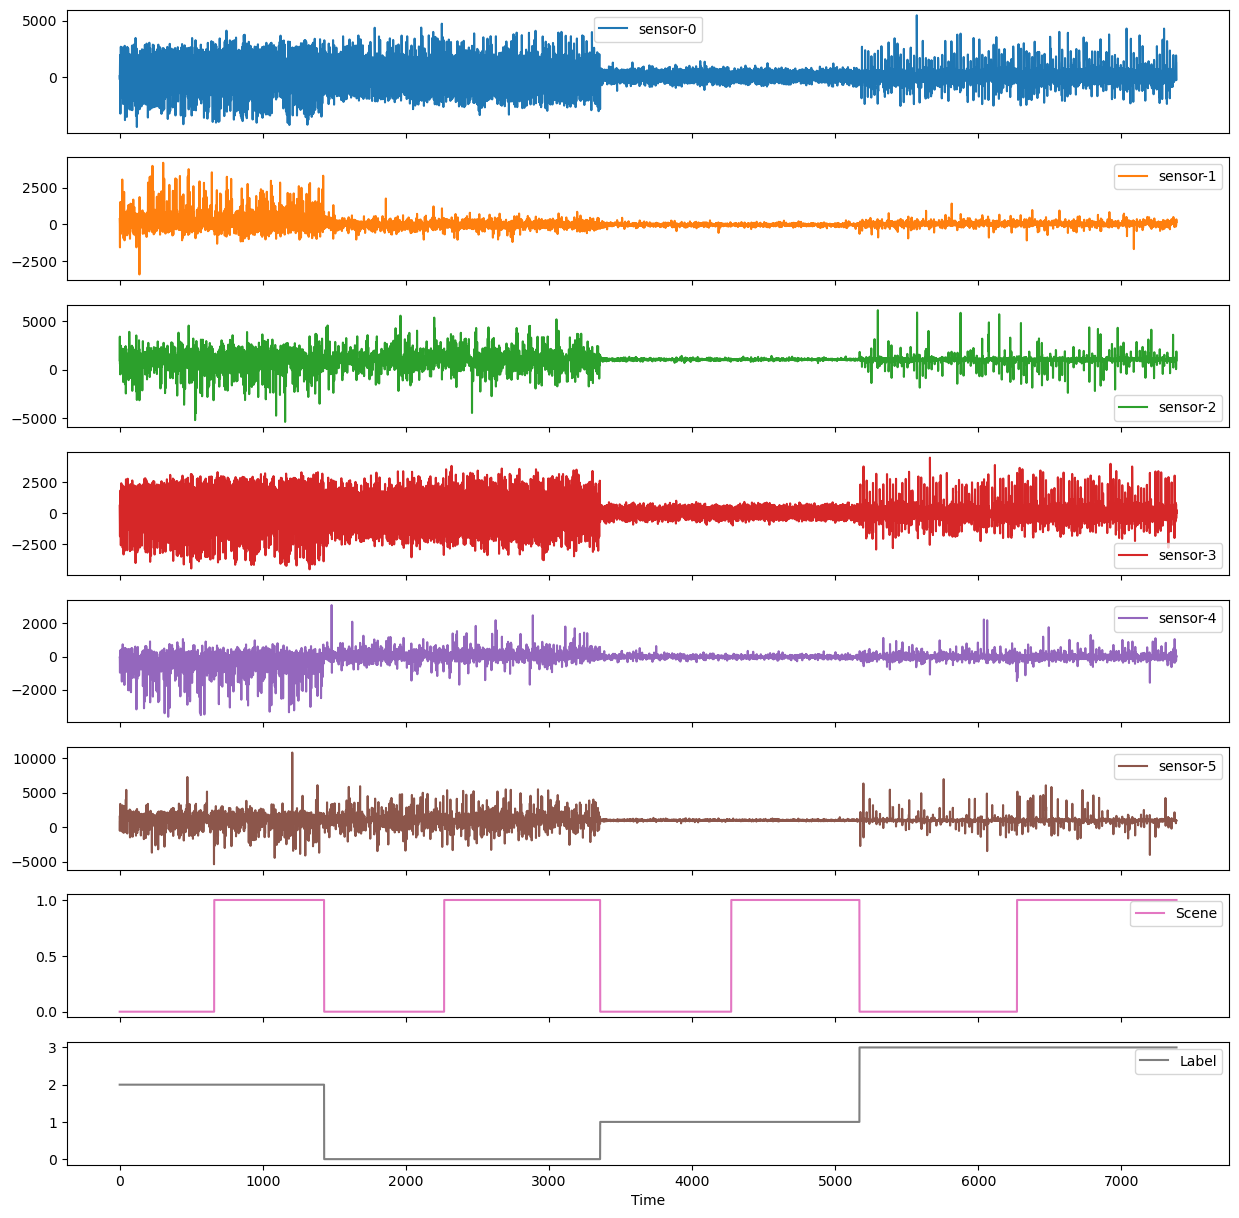

In [25]:
def prinUserSensorMatrix(S,L,Y):
    df = pd.DataFrame()
    ts=[]
    ls=[]
    
    for t in range(0,X.shape[0]):
        ts.append(t)
    df['Time']=ts
    #print(ts)
    for s in range(0,X.shape[2]):
        ls.append("sensor-"+str(s))
        vs=S[:,:,s]
        vs=vs[:,0]
        print(vs.shape)
        df["sensor-"+str(s)]=vs
    

    
    ss=[]
    for t in range(0,X.shape[0]):
        ss.append(L[t])
    df['Scene']=ss
    ls.append('Scene')
    
    ys=[]
    for t in range(0,X.shape[0]):
        ys.append(Y[t])
    df['Label']=ys
    ls.append('Label')

    print(ls)
    
    df.plot(x="Time",y=ls,subplots=True, legend=True, figsize=(15,15))    
    
prinUserSensorMatrix(X,S,Y)

In [26]:
print(X)       
print(X.shape)       

[[[ 7.15795918e+01  3.49539589e+02  9.52030000e+02  5.93899170e+02
   -5.84494005e+01  1.49982000e+03]
  [ 6.60219998e+01  4.10240121e+02  1.00247000e+03  1.60243505e+03
   -1.57205953e+02  1.25975500e+03]
  [-1.40684038e+02  2.76526284e+02  1.32377500e+03  2.16590563e+03
    1.44259606e+02  1.83543000e+03]
  ...
  [ 8.19947585e+01  3.20915827e+02  9.67790000e+02  4.99489292e+00
   -1.70543870e+02  9.77730000e+02]
  [ 7.96925312e+01  3.25653563e+02  9.65365000e+02  5.04414453e+00
   -1.70454189e+02  9.76760000e+02]
  [ 8.00185448e+01  3.25416480e+02  9.66335000e+02  5.24499249e+00
   -1.70533225e+02  9.76760000e+02]]

 [[-2.33732108e+02  1.14493063e+01  3.37769500e+03 -4.50873150e+02
   -1.10638620e+02 -5.26700000e+02]
  [-1.21616818e+03  9.19542788e+02  1.04005500e+03 -9.52498554e+02
   -3.06232653e+02  1.03642000e+03]
  [ 2.76220890e+01 -5.32473837e+01  1.10577000e+03  1.29233667e+03
   -1.53089559e+02  1.01459500e+03]
  ...
  [ 8.01458960e+01  3.25854934e+02  9.68035000e+02  5.21498

In [27]:
Y=to_categorical(Y)

In [28]:
print("nan:",np.argwhere(np.isnan(X)))
print(X[np.argwhere(np.isnan(X))])

nan: []
[]


In [29]:
from tensorflow import keras

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D,Activation, Dense

from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv1D, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense,Dropout,LSTM,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



classes=["S-Herringbone","S-Diagonal","S-DoublePoling","S-KickDoublePoling"]

Y_pred_total=np.array([])
Y_val_total=np.array([])


for sceneid in np.unique(S):

    print("SCENE:",sceneid)
    index_test=np.where(S == sceneid)[0]
    index_train=np.where(S != sceneid)[0]

    print("index_test",index_test)
    print("index_train",index_train)

    x_train=X[index_train]
    x_val=X[index_test]
    y_train=Y[index_train]
    y_val=Y[index_test]

    #normalizamos valores (18 valores=6 señales imu x 3 sensores)
    for ixv in range(0,X.shape[2]):
        print(x_train[:,:,ixv])
        avg_v=np.nanmean(x_train[:,:,ixv].flatten())
        std_v=np.nanstd(x_train[:,:,ixv].flatten())
        print("avg_v,std_v:",avg_v,std_v)
        x_train[:,:,ixv]=(x_train[:,:,ixv]-avg_v)/(std_v)
        x_val[:,:,ixv]=(x_val[:,:,ixv]-avg_v)/(std_v)

    model = keras.Sequential()

    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(X.shape[1],X.shape[2])))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))

    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(256))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Dense(1024))
    model.add(Dense(len(classes), activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train , y_train,
                        batch_size=64,
                validation_data=(x_val,y_val),
                epochs=25)


    y_pred = model.predict(x_val).argmax(axis=1)
    y_val=y_val.argmax(axis=1)
    print(y_pred)
    print(y_val)
    Y_pred_total=np.concatenate((Y_pred_total,y_pred))
    Y_val_total=np.concatenate((Y_val_total,y_val))

    

    

SCENE: 0
index_test [   0    1    2 ... 6268 6269 6270]
index_train [ 661  662  663 ... 7383 7384 7385]
[[-3722.02430299 -3849.01609065 -3472.3359635  ...  1630.74429916
   -365.744319     -54.0625995 ]
 [ -109.70432885  -218.27712666  -717.40093517 ...  1552.53537078
   2837.48943535  2063.60043933]
 [-1171.37961858  -961.82894606   -54.28812482 ...  -187.80949439
    527.79543401   953.50918514]
 ...
 [ 1363.83521632  1419.03748572  2530.11201095 ...  -387.65391283
   -473.5001805   -645.04287453]
 [ 1253.78383987  1351.44042165  1351.44042165 ...   367.51950199
    135.85916565   -68.0111295 ]
 [ -216.52731402  -197.71512943  -301.73217888 ...   559.09791533
    499.40269207   296.67030849]]
avg_v,std_v: 87.40035784629606 1235.394429293733
[[-4.56613659e+02  1.02348706e+03  9.71230298e+02 ... -7.72702930e+01
   2.31615188e+02  3.51520682e+02]
 [ 4.03895440e+02  3.20062749e+02  4.40848859e+02 ...  2.42339982e-01
  -6.34493943e+02 -1.56443864e+02]
 [ 6.67016414e+01  1.57948892e+02  2.

61/61 [==============================] - 33s 535ms/step - loss: 0.0932 - accuracy: 0.9840 - val_loss: 0.0642 - val_accuracy: 0.9892
Epoch 18/25
61/61 [==============================] - 34s 559ms/step - loss: 0.0765 - accuracy: 0.9850 - val_loss: 0.0362 - val_accuracy: 0.9929
Epoch 19/25
61/61 [==============================] - 33s 548ms/step - loss: 0.1090 - accuracy: 0.9775 - val_loss: 0.0695 - val_accuracy: 0.9869
Epoch 20/25
61/61 [==============================] - 34s 552ms/step - loss: 0.0437 - accuracy: 0.9915 - val_loss: 0.0462 - val_accuracy: 0.9903
Epoch 21/25
61/61 [==============================] - 32s 529ms/step - loss: 0.1144 - accuracy: 0.9824 - val_loss: 0.0490 - val_accuracy: 0.9878
Epoch 22/25
61/61 [==============================] - 29s 479ms/step - loss: 0.0410 - accuracy: 0.9956 - val_loss: 0.1620 - val_accuracy: 0.9517
Epoch 23/25
61/61 [==============================] - 34s 560ms/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 0.0619 - val_accuracy: 0.9841
Epoc

55/55 [==============================] - 23s 411ms/step - loss: 0.1139 - accuracy: 0.9724 - val_loss: 0.0298 - val_accuracy: 0.9938
Epoch 9/25
55/55 [==============================] - 23s 416ms/step - loss: 0.1489 - accuracy: 0.9736 - val_loss: 0.0149 - val_accuracy: 0.9974
Epoch 10/25
55/55 [==============================] - 23s 417ms/step - loss: 0.0716 - accuracy: 0.9815 - val_loss: 0.0133 - val_accuracy: 0.9964
Epoch 11/25
55/55 [==============================] - 23s 413ms/step - loss: 0.1042 - accuracy: 0.9764 - val_loss: 0.0210 - val_accuracy: 0.9961
Epoch 12/25
55/55 [==============================] - 23s 413ms/step - loss: 0.0805 - accuracy: 0.9798 - val_loss: 0.0172 - val_accuracy: 0.9964
Epoch 13/25
55/55 [==============================] - 23s 414ms/step - loss: 0.0423 - accuracy: 0.9881 - val_loss: 0.0105 - val_accuracy: 0.9977
Epoch 14/25
55/55 [==============================] - 23s 414ms/step - loss: 0.0473 - accuracy: 0.9881 - val_loss: 0.0169 - val_accuracy: 0.9964
Epoch

[2. 2. 2. ... 3. 3. 3.]
[2. 2. 2. ... 3. 3. 3.]
[[1899    0   22    8]
 [   0 1808    0    4]
 [   4    0 1425    0]
 [   2    5   31 2178]]
Classification Report TOTAL
                    precision    recall  f1-score   support

     S-Herringbone       1.00      0.98      0.99      1929
        S-Diagonal       1.00      1.00      1.00      1812
    S-DoublePoling       0.96      1.00      0.98      1429
S-KickDoublePoling       0.99      0.98      0.99      2216

          accuracy                           0.99      7386
         macro avg       0.99      0.99      0.99      7386
      weighted avg       0.99      0.99      0.99      7386



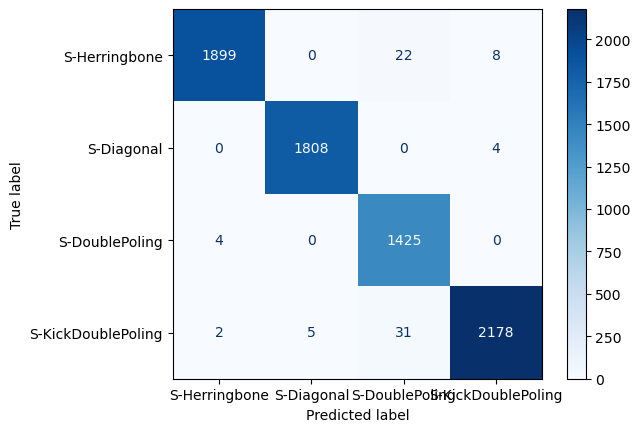

In [30]:
print(Y_pred_total)
print(Y_val_total)

cm = confusion_matrix(Y_val_total, Y_pred_total) 
print(cm)
print('Classification Report TOTAL')
print(classification_report(Y_val_total, Y_pred_total, target_names=classes))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap=plt.cm.Blues)
plt.show()